In [1]:
import os
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import chromadb
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Literal
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv


In [2]:
# ----------------------------
# Load environment variables
load_dotenv()

True

In [3]:
# ----------------------------
# Define the embedding model and vector store
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

persistent_client = chromadb.PersistentClient()
vector_store_from_client = Chroma(
    client=persistent_client,
    collection_name="contract_collection",
    embedding_function=hf,
)
retriever = vector_store_from_client.as_retriever()

# ----------------------------
# Define our tools

@tool
def retrieve_from_vectorstore(search_string: str) -> str:
    """
    Retrieves information about Federal Employee Program (FEP) in Blue Cross Blue Shield based on the provided query.
    """
    retrieved_docs = retriever.invoke(search_string)
    # Return the page content from all retrieved docs as one string.
    return "\n".join(doc.page_content for doc in retrieved_docs)

@tool
def ddg_search(search_string: str) -> str:
    """Searches the internet based on the user query."""
    search = DuckDuckGoSearchRun()
    search_results = search.invoke(search_string)
    # If multiple results are returned, join them into a single string.
    if isinstance(search_results, list):
        return "\n".join(search_results)
    return search_results

# ----------------------------
# Set up the LLM and the supervisor prompt

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=os.getenv("OPENAI_API_KEY"),
)

# Define agent names.
members = ["retriever_agent", "internet_search_agent", "small_talk_agent"]
options = members + ["FINISH"]

# Define agent descriptions.
retriever_definition = "Retrieves information about Insurance policies based on the provided query."
internet_search_definition = "Searches the internet based on the user query."
small_talk_definition = "Engages in general conversation when no specific retrieval is needed."

system_prompt = (
    "You are a supervisor managing a conversation between the following workers:\n"
    "1. retriever_agent: " + retriever_definition + "\n"
    "2. internet_search_agent: " + internet_search_definition + "\n"
    "3. small_talk_agent: " + small_talk_definition + "\n\n"
    "Look at the conversation history and decide which worker should act next to help answer the user’s query. "
    "If no further action is needed or the query is not relevant, respond with FINISH."
)

# Define the expected structure of the supervisor's output.
class Router(TypedDict):
    next: Literal["retriever_agent", "internet_search_agent", "small_talk_agent", "FINISH"]

class State(MessagesState):
    next: str

def supervisor_node(state: State) -> Command[Literal["retriever_agent", "internet_search_agent", "small_talk_agent", "final_response_node"]]:
    # Prepend the system prompt to the conversation.
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    print("Supervisor response:", response)
    
    # Attempt to extract the 'next' value.
    next_value = response.get("next")
    if next_value is None and "properties" in response:
        next_value = response["properties"].get("next")
    if next_value is None:
        raise ValueError("Structured output did not contain 'next'")
    
    if next_value == "FINISH":
        return Command(goto="final_response_node")
    return Command(goto=next_value, update={"next": next_value})

# ----------------------------
# Create the agent nodes

# The retriever agent uses the vector store tool.
retrieve_agent = create_react_agent(
    llm,
    tools=[retrieve_from_vectorstore],
    prompt="You are a retriever agent. Provide relevant background information without doing any math."
)

# The internet search agent uses the DuckDuckGo search tool.
internet_agent = create_react_agent(
    llm,
    tools=[ddg_search],
    prompt="You are an internet search agent. Provide current information based on an online search without doing any math."
)

def small_talk_agent_node(state: State) -> Command[Literal["__end__"]]:
    result = llm.invoke(state["messages"])
    return Command(
        update={"messages": [HumanMessage(content=result.content, name="small_talk_agent")]},
        goto=END,
    )

def retrieve_agent_node(state: State) -> Command[Literal["supervisor"]]:
    result = retrieve_agent.invoke(state)
    print("Retriever agent result:", result)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="retriever_agent"
                )
            ]
        },
        goto="supervisor",
    )

def internet_search_agent_node(state: State) -> Command[Literal["supervisor"]]:
    result = internet_agent.invoke(state)
    print("Internet search agent result:", result)
    # Tag the message correctly with the agent's name.
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content,
                    name="internet_search_agent"
                )
            ]
        },
        goto="supervisor",
    )

def final_response_node(state: State) -> Command[Literal["__end__"]]:
    final_response = llm.invoke([
        {"role": "system", "content": "Provide a final, elaborate answer to the user’s most recent query using all available context."},
        *state["messages"],
    ])
    return Command(
        update={"messages": [AIMessage(content=final_response.content, name="final_response")]},
        goto=END,
    )

# ----------------------------
# Build the Langgraph state graph

builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("retriever_agent", retrieve_agent_node)
builder.add_node("internet_search_agent", internet_search_agent_node)
builder.add_node("small_talk_agent", small_talk_agent_node)
builder.add_node("final_response_node", final_response_node)
builder.add_edge(START, "supervisor")

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

/usr/local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2025-02-10 00:02:43.261054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


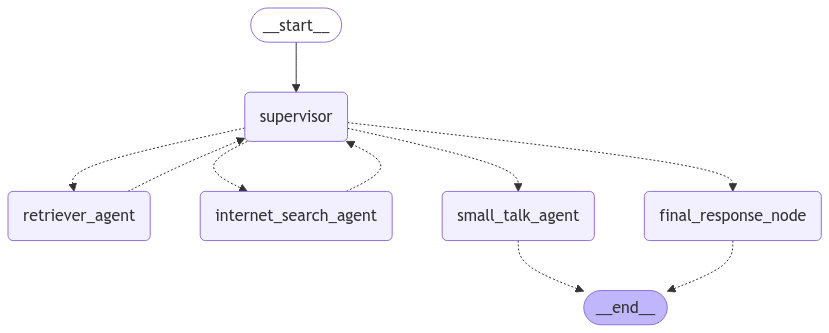

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
input_message = {"type": "user", "content":"Hi"}
config = {"configurable": {"thread_id": "1"}}
                           
async for chunk in graph.astream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi
Supervisor response: {'next': 'small_talk_agent'}
================================ Human Message =================================

Hi
================================ Human Message =================================
Name: small_talk_agent

Hello! How can I assist you today?


In [6]:
input_message = {"type": "user", "content":"How many WDC's and CDC's does ferrari F1 team have?"}
config = {"configurable": {"thread_id": "1"}}
                           
async for chunk in graph.astream({"messages": [input_message]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

How many WDC's and CDC's does ferrari F1 team have?
Supervisor response: {'next': 'internet_search_agent'}
================================ Human Message =================================

How many WDC's and CDC's does ferrari F1 team have?
Internet search agent result: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='26240007-9bab-494e-9f87-eab0982cd1a7'), HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, name='small_talk_agent', id='05f36658-b1f9-4ca6-9b65-b6bc557d58e7'), HumanMessage(content="How many WDC's and CDC's does ferrari F1 team have?", additional_kwargs={}, response_metadata={}, id='bfc3ddb4-4725-4876-b01f-1a8251480682'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_42rrIc7cgR4aXBe5T8KNKUnc', 'function': {'arguments': '{"search_string": "Ferrari F1 team World Drivers Championsh